In [171]:
import pandas as pd
import numpy as np
import sklearn
import zipfile
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
import warnings
from pandas.core.common import SettingWithCopyWarning
from sklearn.feature_selection import chi2, SelectKBest, f_regression
from scipy.cluster import hierarchy 
from category_encoders import TargetEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LassoCV, RidgeCV

In [134]:
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

Steps:
- Identify relevant features for the prediction task
- Features leak target information?
- Show visualizations or statistics to support your selection
- Not required to use the description column, but can try to come up with relevatn features from it

## Task 1

In [135]:
df = pd.read_csv('data/vehicles.csv')

Drop all rows which have 0 price. For the scope of this regression problem, having 0 does not mean that the car is free but that the user decided to not list a price, possibly to prevent potential buyers from being intimidated by a large number. Thus, for such cases, 0 price is not representative of the car's actual value

In [136]:
df = df[df['price']!= 0]

Subsample the data

In [137]:
sample_frac = 0.10
df = df.sample(frac=sample_frac)

In [138]:
# Take the price column out
# Also drop the description column as it includes the price which may be leaking the target
price = df.price
X = df.drop(columns='price')

Drop repetitive data such as the region_url, which contains the same information as 'region'.
Also drop 'url' which contains the same information as 'region', 'make', and 'model'.
Drop 'image_url' as all are images.craiglist. Drop 'vin' as it is are unique for every single data sample and therefore, not important for predicting price. Also drop description as this may include the price, thereby leaking the target, while providing uncessary information. Drop 'county' as the entire column in NaN and therefore, adds 0 value in predicting the price.

In [139]:
columns_to_drop = ['url', 'region_url', 'description', 'county']
X = X.drop(columns=columns_to_drop)

Get the relative datatypes of the different columns (i.e. if it is object vs float).
Also figure out which columns contain NaN values which need to be imputed

In [140]:
data_obj = [col for col in X.columns if X[col].dtype == 'object']
data_float = [col for col in X.columns if X[col].dtype != 'object']
cols_nan = X.columns[X.isna().any()].tolist()
data_obj_missing = [col for col in data_obj if col in cols_nan]
data_float_missing = [col for col in data_float if col in cols_nan]

In [141]:
impute_categorical = SimpleImputer(strategy='most_frequent', missing_values=np.nan)
impute_float = SimpleImputer(strategy='median',missing_values=np.nan)

In [142]:
X[data_obj_missing] = impute_categorical.fit_transform(X[data_obj_missing])

In [143]:
X[data_float_missing] = impute_float.fit_transform(X[data_float_missing])

## Numerical Data: High level feature analysis

Plot continuous data to get an idea of feature importance

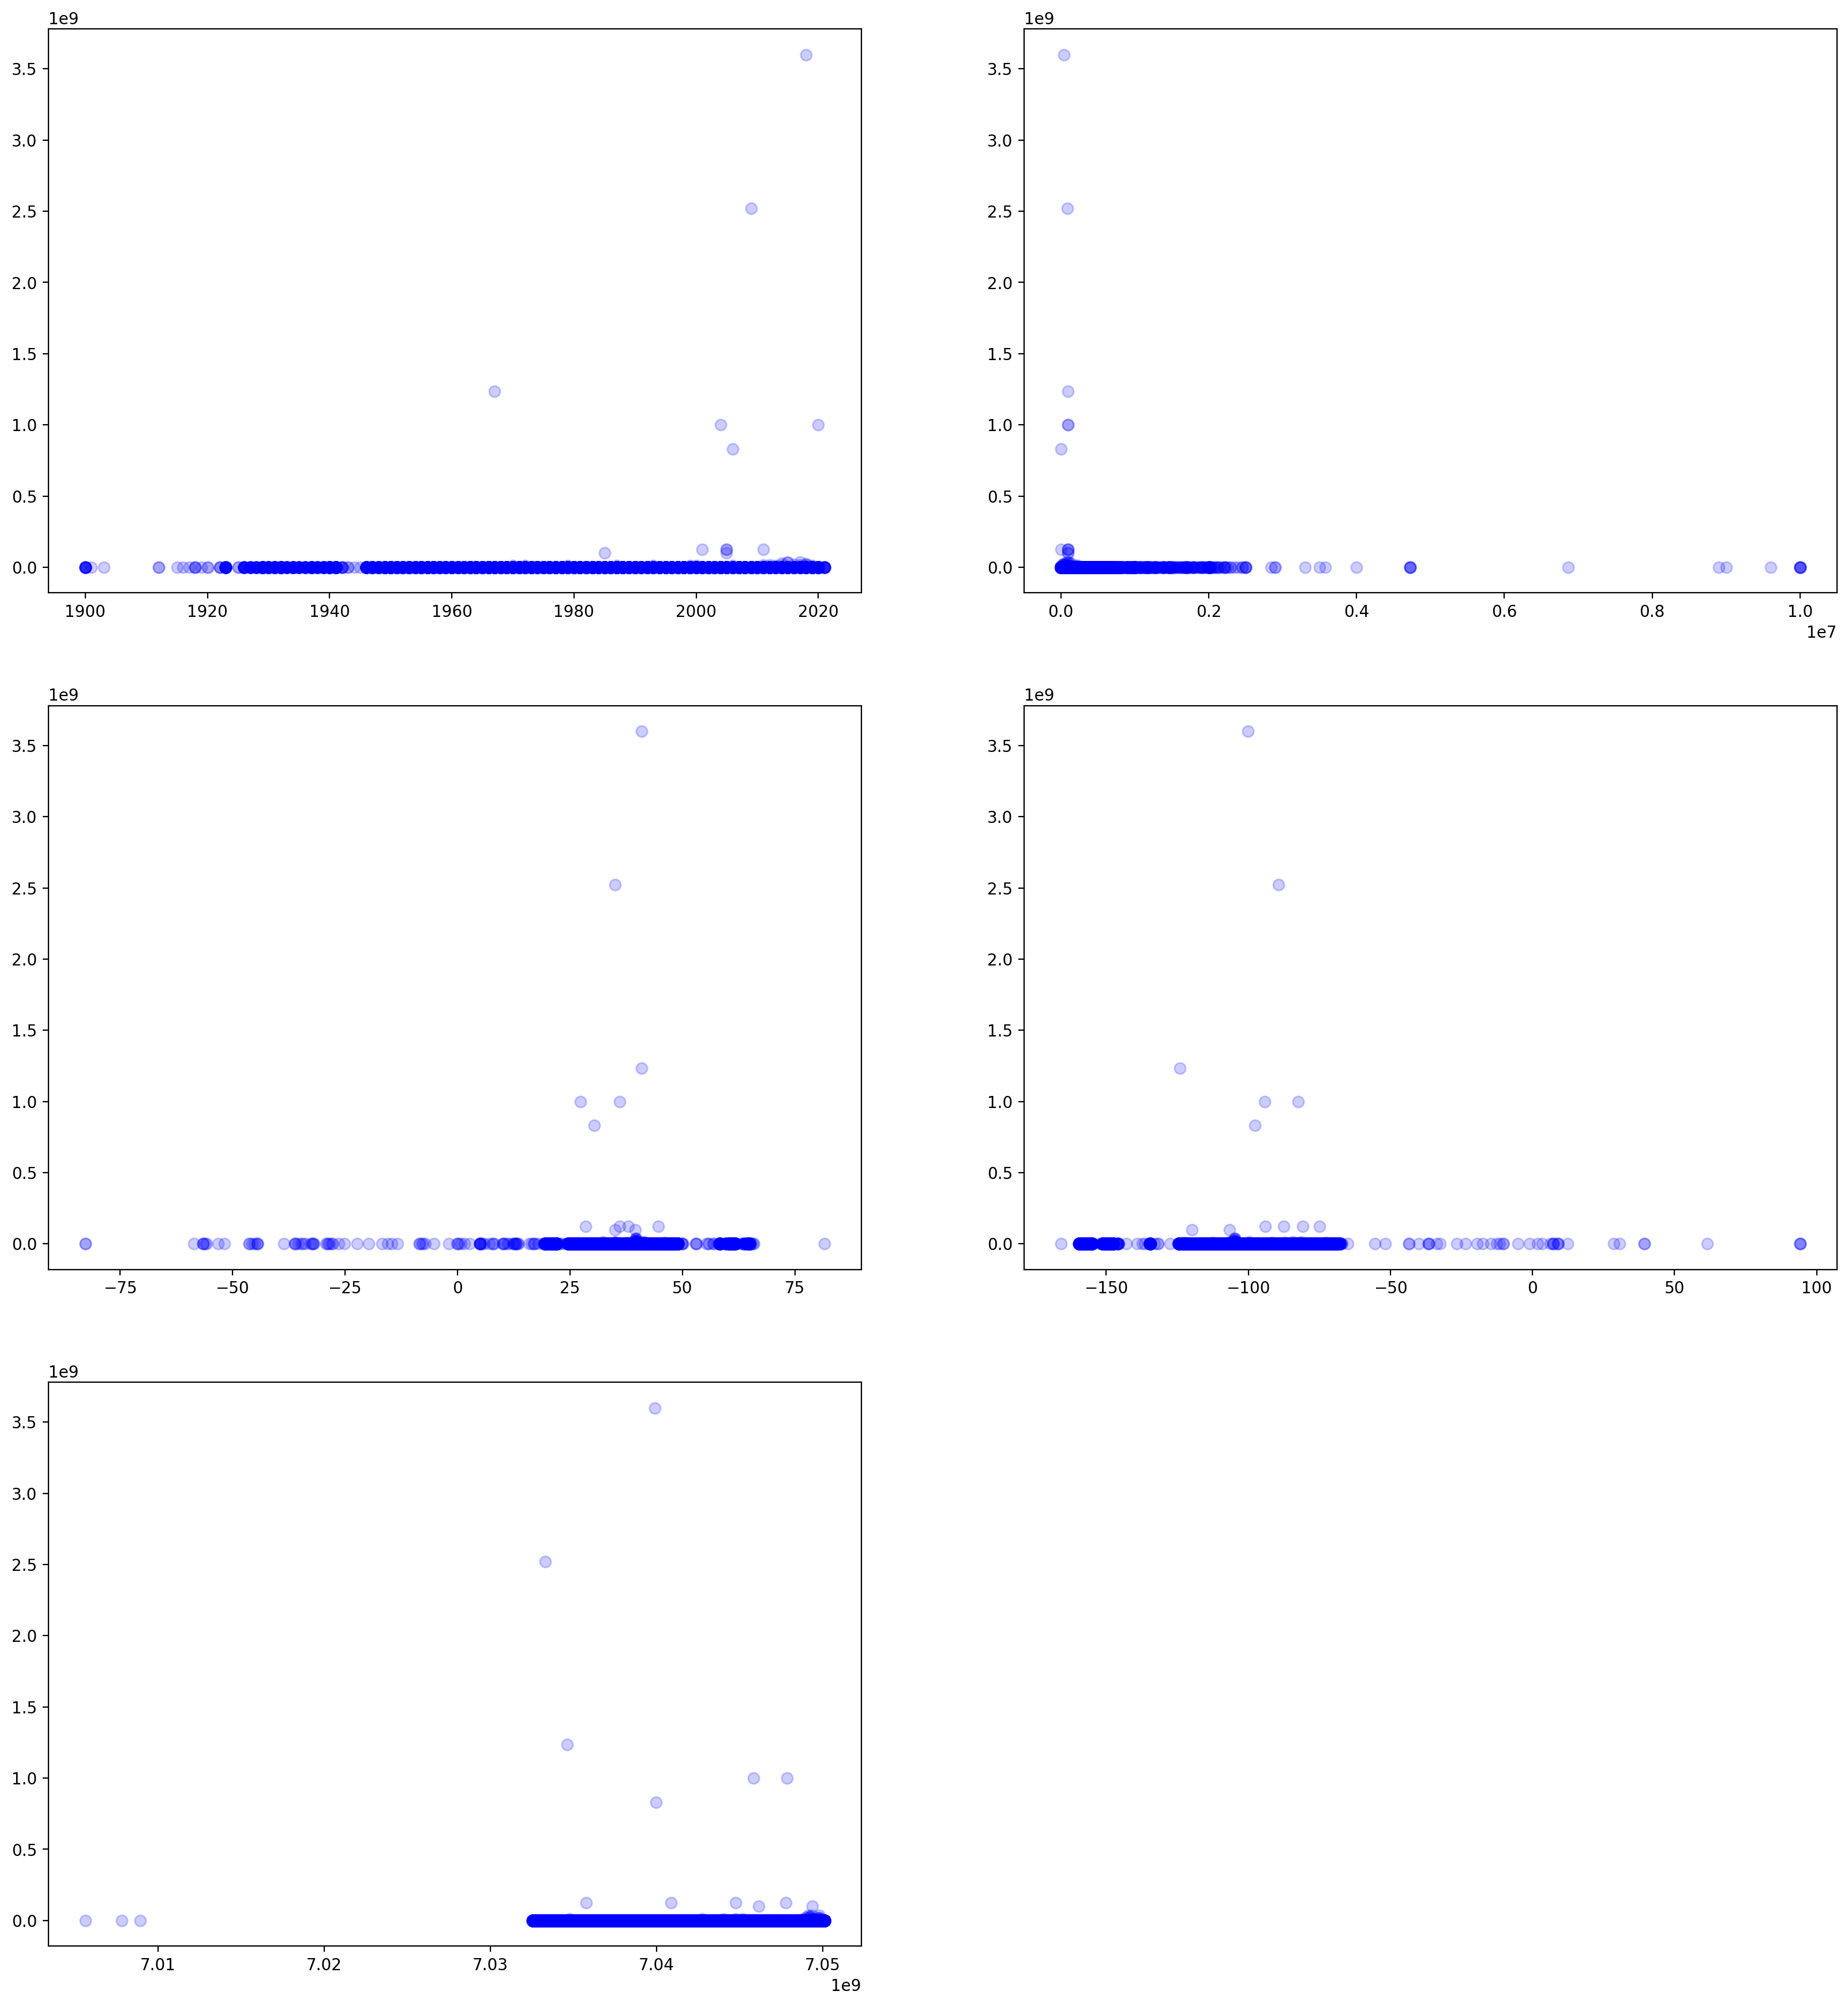

In [41]:
fig, ax = plt.subplots(3, 2, figsize=(20,22), dpi=200)
ax1, ax2, ax3, ax4, ax5, ax6 = ax.ravel()

ax1.plot(X['year'], price, 'bo', alpha=0.2, markersize=7)
ax2.plot(X['odometer'], price, 'bo', alpha=0.2, markersize=7)
ax3.plot(X['lat'], price, 'bo', alpha=0.2, markersize=7)
ax4.plot(X['long'], price, 'bo', alpha=0.2, markersize=7)
ax5.plot(X['id'], price, 'bo', alpha=0.2, markersize=7)
ax6.remove()
plt.show()

Adjust y-lims to see data further zoomed in

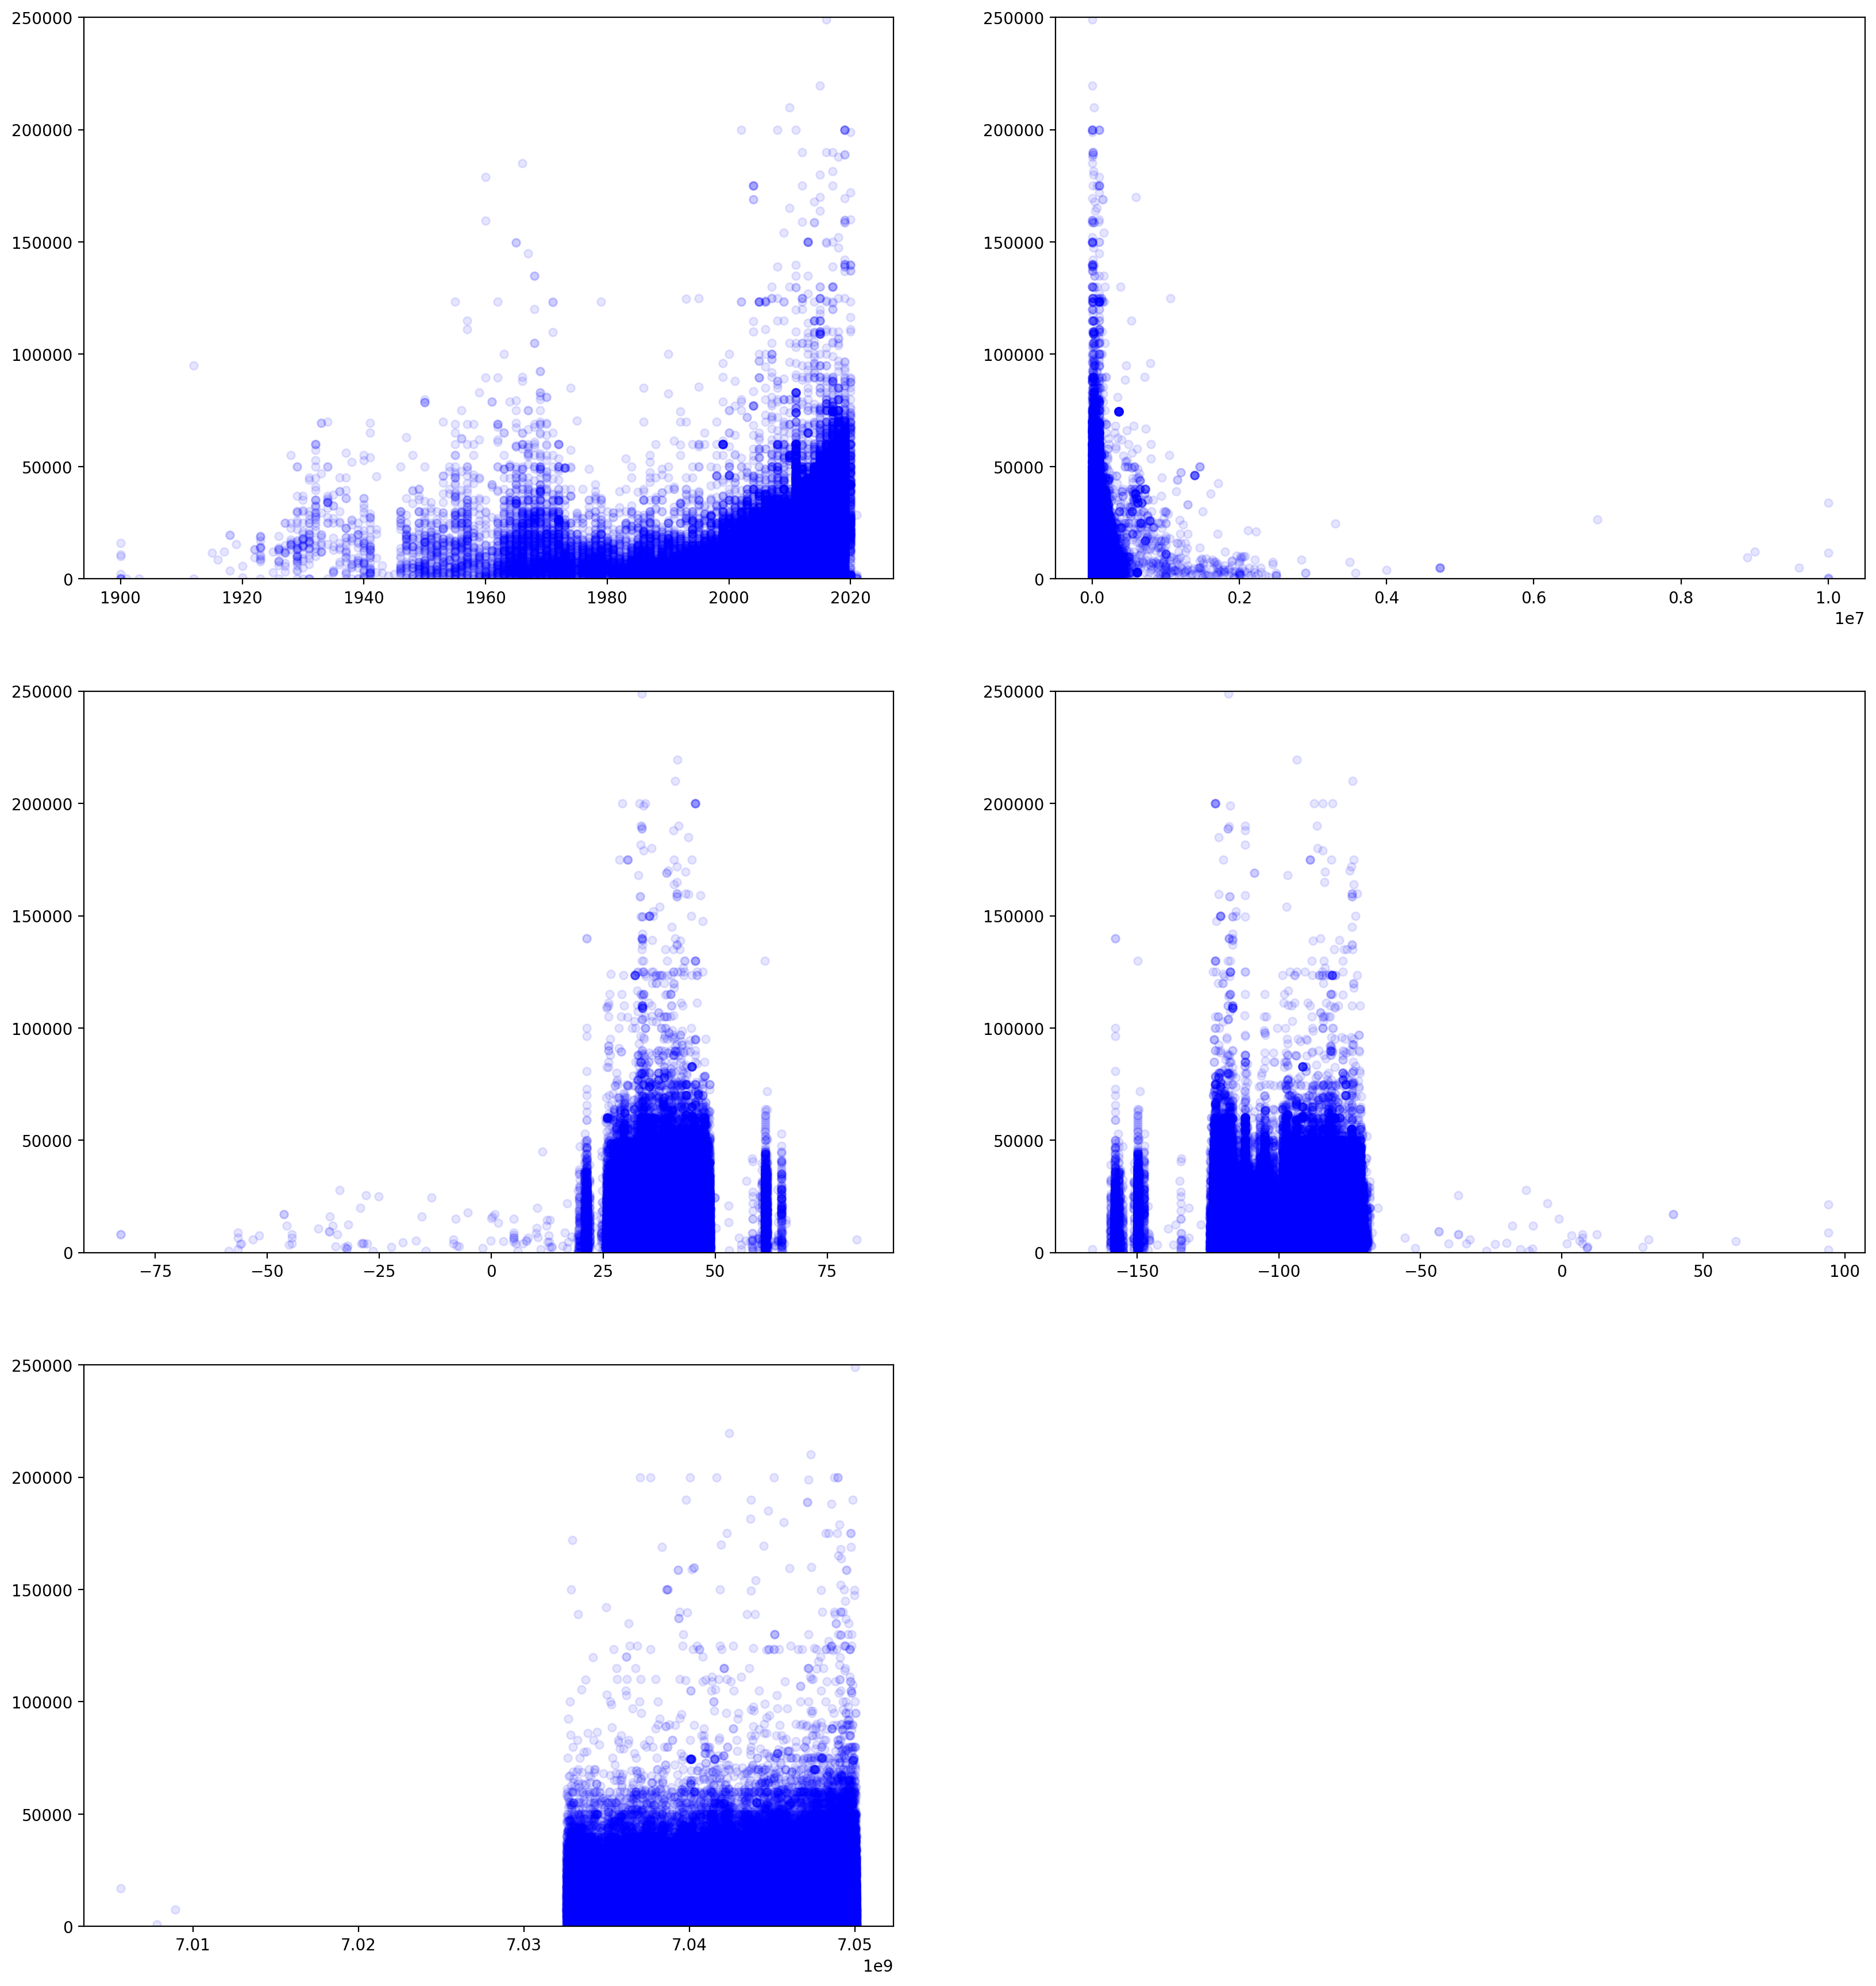

In [42]:
fig, ax = plt.subplots(3, 2, figsize=(20,22), dpi=200)
ax1, ax2, ax3, ax4, ax5, ax6 = ax.ravel()

ax1.plot(X['year'], price, 'bo', alpha=0.1, markersize=5)
ax1.set_ylim(-10, 0.00025E9)

ax2.plot(X['odometer'], price, 'bo', alpha=0.1, markersize=5)
ax2.set_ylim(-10, 0.00025E9)

ax3.plot(X['lat'], price, 'bo', alpha=0.1, markersize=5)
ax3.set_ylim(-10, 0.00025E9)

ax4.plot(X['long'], price, 'bo', alpha=0.1, markersize=5)
ax4.set_ylim(-10, 0.00025E9)

ax5.plot(X['id'], price, 'bo', alpha=0.1, markersize=5)
ax5.set_ylim(-10, 0.00025E9)

ax6.remove()
plt.show()

One can calculate the correlation between each of the numeric features and the price to quantify their possible relation

In [14]:
for col in data_float:
    print(f'Feature:  {col}')
    print(f'Correlation with price: {X[col].corr(price)}')

Feature:  id
Correlation with price: 0.004566860721877466
Feature:  year
Correlation with price: 0.0018209963086134927
Feature:  odometer
Correlation with price: -0.001346725531758418
Feature:  lat
Correlation with price: -0.005278651265704601
Feature:  long
Correlation with price: 0.0026536217255698114


Calculate covariance values

In [33]:
cov = abs(X[data_float].corr().to_numpy())
order = np.array(hierarchy.dendrogram(hierarchy.ward(cov),no_plot=True)['ivl'], dtype=int)
sorted_keys = [data_float[x] for x in order]

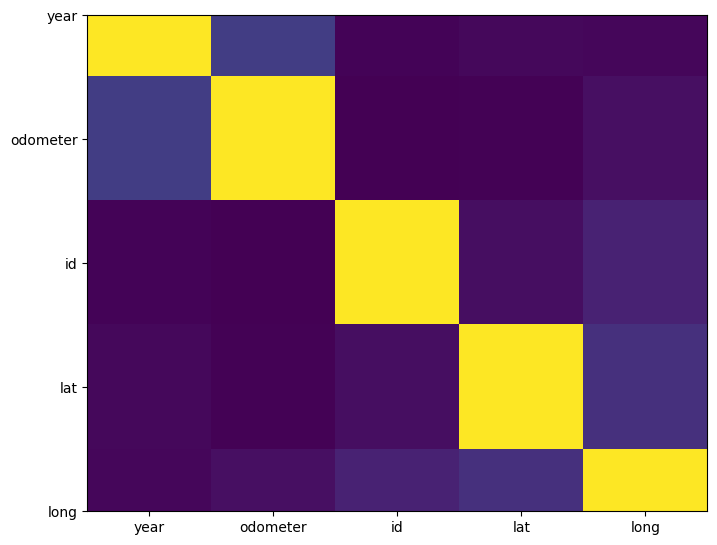

In [34]:
plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(cov[order, :][:, order])
plt.xticks(range(len(sorted_keys)), sorted_keys)
plt.yticks(range(len(sorted_keys)), sorted_keys)
plt.show()

Based on the above results, drop id based on graph and also correlation. Could also potentially drop odometer because doesnt show a strong coorelation to price and is correlated to the year. Potentially drop latitude and longitude as they display a fairly uniform distribution when plotted vs price.

## Categorical Data: High Level Feature Analysis

In [104]:
# Ordinal Encoding, maybe target encode?
ordinal_encoder = preprocessing.OrdinalEncoder()
ordinal_encoder.fit(X[data_obj])
X_ordinal = ordinal_encoder.transform(X[data_obj])

In [105]:
fs = SelectKBest(score_func=f_regression, k='all')
fs.fit(X_ordinal, price)
scores = fs.scores_

In [106]:
score_feature_pairs = list(zip(fs.scores_, data_obj, fs.pvalues_))
sorted_list = sorted(score_feature_pairs)
for item in sorted_list:
    print(f'Category: {item[1]}, {item[0]}, {item[2]}')

Category: image_url, 0.023792132118115317, 0.8774151310399585
Category: fuel, 0.024688683912299305, 0.8751454222723614
Category: type, 0.23508876239650764, 0.6277764484006509
Category: title_status, 0.2770293470153411, 0.5986554323328023
Category: paint_color, 0.360140333801946, 0.5484288916668101
Category: manufacturer, 0.45664011352761524, 0.49919909178054733
Category: state, 0.4981532526551262, 0.4803133983991472
Category: drive, 0.9933493546497669, 0.31892617354872554
Category: model, 0.9999061570360465, 0.3173342546336977
Category: condition, 1.0984123486099395, 0.2946158787252619
Category: cylinders, 1.8076604336082742, 0.17879044678759634
Category: region, 2.0490475477493253, 0.15230278402303674
Category: size, 3.6964562790982476, 0.0545293801510592
Category: vin, 3.861893796863559, 0.04939573140856954
Category: transmission, 11.329062704149482, 0.0007631572212845547


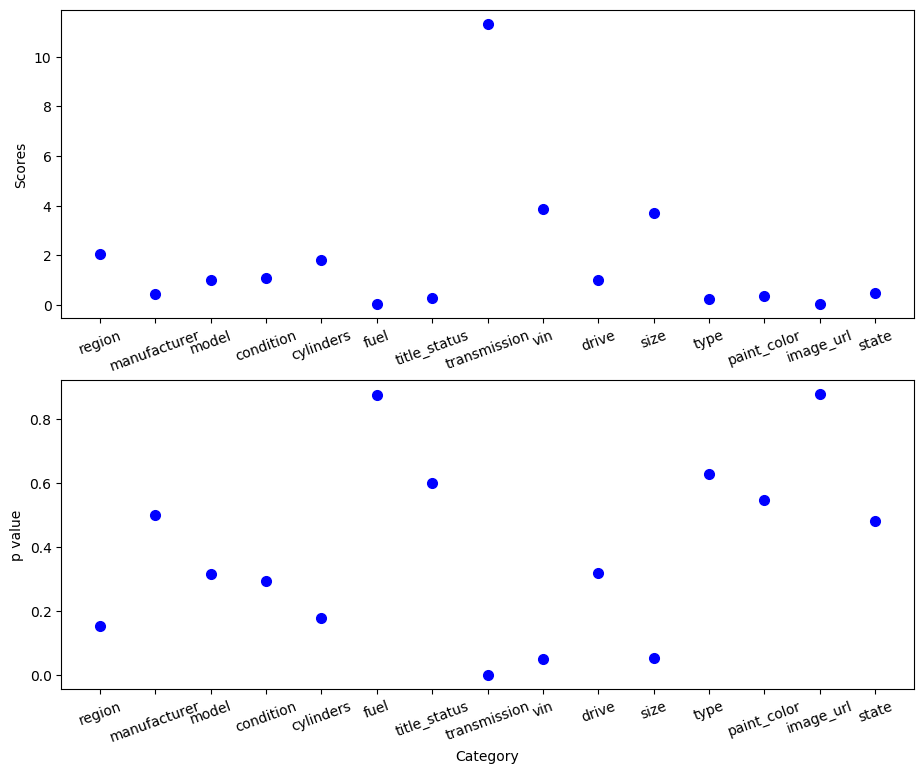

In [129]:
fig, ax = plt.subplots(2, 1, figsize=(11,9), dpi=100)
ax1, ax2 = ax.ravel()
ax1.plot(fs.scores_, 'bo', markersize=7)
ax1.set_xticks(range(len(data_obj)))
ax1.set_xticklabels(labels=data_obj, rotation=20)
ax1.set_ylabel('Scores')
ax1.set_xlabel('Category')

ax2.plot(fs.pvalues_, 'bo', markersize=7)
ax2.set_xticks(range(len(data_obj)))
ax2.set_xticklabels(labels=data_obj, rotation=20)
ax2.set_ylabel('p value')
ax2.set_xlabel('Category')
plt.show()

- Null Hypothesis: All the regression coefficients are 0
- If sig value < p value, then can conlude the value is important
- Very low F scores to indicate lower cross-correlation

Based on the f_regression test using the categorical variables, it can be seen that transmission has a high score with a very small p value (lower than the significance level of 0.01), and therefore, it is an important feature to keep going forward. While vin and size also produce large values with small p-values, these rows consist of significantly imputed results (67% for size and 41% for vin), therefore, these numbers may not be well representative of significance. Vin, more specifically, is an identification number and therefore, should not impact price. It was therefore be dropped in the next steps. On the other end of the spectrum, image_url produced the lowest f_score with the highest p-value, indicating that this feature can be dropped going forward. 

## Task 2

In [144]:
rows_to_drop = ['id', 'vin', 'image_url', 'odometer']

In [145]:
X = X.drop(columns=rows_to_drop)

In [146]:
X

,region,year,manufacturer,model,condition,cylinders,fuel,title_status,transmission,drive,size,type,paint_color,state,lat,long
467294,clarksville,2014.0,ford,mustang,excellent,6 cylinders,gas,clean,automatic,rwd,full-size,coupe,white,tn,36.3023,-86.6369
339853,raleigh / durham / CH,2004.0,jeep,grand cherokee,good,6 cylinders,gas,clean,automatic,rwd,full-size,wagon,silver,nc,35.7109,-78.6600
18695,bellingham,2015.0,gmc,sierra 1500,excellent,8 cylinders,gas,clean,automatic,4wd,full-size,truck,white,wa,48.7550,-122.4660
91712,los angeles,2011.0,honda,accord lx.4door,excellent,other,gas,clean,automatic,fwd,full-size,sedan,white,ca,33.8903,-118.1420
135953,denver,2011.0,nissan,juke sv awd,excellent,4 cylinders,gas,clean,automatic,4wd,compact,sedan,white,co,39.6200,-104.9880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465166,chattanooga,2013.0,chevrolet,express,excellent,6 cylinders,gas,clean,automatic,fwd,full-size,van,white,tn,35.9233,-84.0607
464667,sioux falls / SE SD,2013.0,chevrolet,express 2500 cargo,excellent,8 cylinders,other,clean,automatic,rwd,full-size,other,white,sd,43.5566,-96.8028
485939,corpus christi,2015.0,nissan,altima,excellent,4 cylinders,gas,clean,automatic,fwd,full-size,sedan,white,tx,27.7053,-97.4252
454671,charleston,2012.0,ram,3500 crew cab laramie pickup,good,6 cylinders,diesel,clean,other,4wd,full-size,pickup,white,sc,32.7800,-79.9900


In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, price, shuffle=True, random_state=0)
cv_strategy = KFold(n_splits=10, shuffle=True, random_state=0)

In [148]:
# Remove features which were dropped
data_obj_refined = [x for x in data_obj if x not in rows_to_drop]
data_float_refined = [x for x in data_float if x not in rows_to_drop]
target_encode = ['model', 'region', 'state', 'manufacturer']

Simple pre-processing and encoding on the selected features

In [149]:
# Add target encoded variables to float type such that they are also scaled
# and remove the features from the list of categorical features
data_obj_refined = [x for x in data_obj_refined if x not in target_encode]
data_float_refined.extend(target_encode)

In [150]:
te = TargetEncoder()
X_train[target_encode] = te.fit_transform(X_train[target_encode], y_train)

In [151]:
X_train

,region,year,manufacturer,model,condition,cylinders,fuel,title_status,transmission,drive,size,type,paint_color,state,lat,long
151941,12619.375000,2017.0,11449.771812,46119.023342,excellent,6 cylinders,gas,clean,manual,4wd,full-size,hatchback,white,12619.375000,38.7627,-77.4618
9767,9731.237838,2014.0,15105.163180,11156.691029,excellent,6 cylinders,gas,clean,automatic,4wd,full-size,sedan,black,11744.706468,36.9152,-76.2151
302693,12294.861905,2005.0,14570.175851,14336.740426,good,8 cylinders,gas,clean,automatic,4wd,mid-size,SUV,grey,12551.949468,44.9063,-93.0478
130580,11349.938776,2015.0,10451.400000,120862.323090,excellent,4 cylinders,gas,clean,automatic,fwd,mid-size,sedan,black,47009.494018,39.1453,-121.5960
431225,14587.240196,2014.0,8966.761017,120862.323090,like new,4 cylinders,gas,clean,automatic,fwd,full-size,sedan,silver,15244.684765,45.6418,-122.6250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256708,14913.279661,2008.0,12770.301741,14369.708344,excellent,6 cylinders,gas,clean,automatic,4wd,full-size,sedan,white,14326.720755,30.2726,-89.7290
473502,16652.417840,2018.0,8209.775748,23861.916929,good,6 cylinders,gas,clean,automatic,fwd,full-size,mini-van,white,14094.082730,34.9304,-88.5414
439310,11503.657895,2014.0,14193.817017,8280.507692,excellent,4 cylinders,gas,clean,automatic,fwd,sub-compact,sedan,blue,12336.852888,40.2118,-76.2355
77994,11074.607453,2011.0,479383.470287,8513.803922,good,4 cylinders,gas,clean,automatic,4wd,mid-size,sedan,silver,15408.163121,33.4113,-94.1774


In [152]:
cat_encoding = Pipeline([('encode', preprocessing.OneHotEncoder(handle_unknown='ignore'))]) 
cont_encoding = Pipeline([('scale', preprocessing.StandardScaler())])
target_encoding = Pipeline([('target', TargetEncoder())])
processing_pipe = make_column_transformer((cont_encoding, data_float_refined),
                                        (cat_encoding, data_obj_refined), 
                                        remainder='passthrough')

In [153]:
lasso_pipe = make_pipeline(processing_pipe, Lasso())
param_grid = {'lasso__alpha': np.logspace(-1,10,10)}
lasso_grid = GridSearchCV(lasso_pipe, param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
lasso_grid.fit(X_train, y_train)
lasso_grid.best_score_

-47.61104213032843

In [154]:
ridge_pipe = make_pipeline(processing_pipe, Ridge())
param_grid = {'ridge__alpha': np.logspace(-1,10,10)}
ridge_grid = GridSearchCV(ridge_pipe, param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
ridge_grid.fit(X_train, y_train)
ridge_grid.best_score_

-47.60958171587205

## Task 3

Further removing features which had a low chi-square score with high p-values

In [155]:
more_rows = ['long', 'lat', 'title_status', 'fuel', 'type']
X_train = X_train.drop(columns=more_rows)

In [156]:
data_obj_refined = [x for x in data_obj_refined if x not in more_rows]
data_float_refined = [x for x in data_float_refined if x not in more_rows]

In [157]:
cat_encoding = Pipeline([('encode', preprocessing.OneHotEncoder(handle_unknown='ignore'))]) 
cont_encoding = Pipeline([('scale', preprocessing.StandardScaler())])
processing_pipe = make_column_transformer((cont_encoding, data_float_refined),
                                        (cat_encoding, data_obj_refined), 
                                        remainder='passthrough')

In [158]:
lasso_pipe = make_pipeline(processing_pipe, Lasso())
param_grid = {'lasso__alpha': np.logspace(-1,10,10)}
lasso_grid = GridSearchCV(lasso_pipe, param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
lasso_grid.fit(X_train, y_train)
lasso_grid.best_score_

-47.61104213032843

In [159]:
ridge_pipe = make_pipeline(processing_pipe, Ridge())
param_grid = {'ridge__alpha': np.logspace(-1,10,10)}
ridge_grid = GridSearchCV(ridge_pipe, param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
ridge_grid.fit(X_train, y_train)
ridge_grid.best_score_

-47.60966513049387

Experimenting with polynomial features

In [175]:
ridge_pipe_with_poly = make_pipeline(processing_pipe, preprocessing.PolynomialFeatures(), Ridge())
param_grid = {'ridge__alpha': np.logspace(-1,10,10)}
ridge_grid = GridSearchCV(ridge_pipe_with_poly, param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
ridge_grid.fit(X_train, y_train)
ridge_grid.best_score_

-116.38417259304954

In [176]:
lasso_pipe = make_pipeline(processing_pipe, preprocessing.PolynomialFeatures(), Lasso())
param_grid = {'lasso__alpha': np.logspace(-1,10,10)}
lasso_grid = GridSearchCV(lasso_pipe, param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
lasso_grid.fit(X_train, y_train)
lasso_grid.best_score_

-47.61104213032843

Comparing cross-validations scores with and without imputed values

Some of the columns had many missing values and therefore, imputing may not be any better than dropping the column altogether

With and without the feature condition 'condition'

In [180]:
# with and without condition 
to_drop = 'condition'
X_without_condition = X_train.drop(columns=to_drop)
data_obj_refined = [x for x in data_obj_refined if x != to_drop]

In [187]:
processing_pipe = make_column_transformer((cont_encoding, data_float_refined),
                                        (cat_encoding, data_obj_refined), 
                                        remainder='passthrough')

In [188]:
lasso_pipe = make_pipeline(processing_pipe, Lasso())
param_grid = {'lasso__alpha': np.logspace(-1,10,10)}
lasso_grid = GridSearchCV(lasso_pipe, param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
lasso_grid.fit(X_without_condition, y_train)
lasso_grid.best_score_

-47.61104213032843

In [189]:
ridge_pipe = make_pipeline(processing_pipe, Ridge())
param_grid = {'ridge__alpha': np.logspace(-1,10,10)}
ridge_grid = GridSearchCV(ridge_pipe, param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
ridge_grid.fit(X_without_condition, y_train)
ridge_grid.best_score_

-47.60968430864029

With and without the feature 'size'

In [190]:
to_drop = 'size'
X_without_size = X_train.drop(columns=to_drop)
data_obj_refined.append('condition')
data_obj_refined = [x for x in data_obj_refined if x != to_drop]

In [192]:
processing_pipe = make_column_transformer((cont_encoding, data_float_refined),
                                        (cat_encoding, data_obj_refined), 
                                        remainder='passthrough')

In [194]:
lasso_pipe = make_pipeline(processing_pipe, Lasso())
param_grid = {'lasso__alpha': np.logspace(-1,10,10)}
lasso_grid = GridSearchCV(lasso_pipe, param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
lasso_grid.fit(X_without_size, y_train)
lasso_grid.best_score_

-47.61104213032843

In [195]:
ridge_pipe = make_pipeline(processing_pipe, Ridge())
param_grid = {'ridge__alpha': np.logspace(-1,10,10)}
ridge_grid = GridSearchCV(ridge_pipe, param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
ridge_grid.fit(X_without_size, y_train)
ridge_grid.best_score_

-47.60967277558871

Other feature engineering things
- Other imputing methods (KNN imputing for numerical)
- Hash encoding for categorical 
- I think this should be using the normal cross val vs grid search after we find optimal features
- What other feature engineering methods can we apply?
- This has something for interactions https://heartbeat.fritz.ai/a-practical-guide-to-feature-engineering-in-python-8326e40747c8